# Определение перспективного тарифа для телеком компании

Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей уловной компании: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.  
  
Компания всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.  
  
#### Задача
Проанализировать поведение клиентов и сделать вывод — какой тариф лучше.  

### Описание тарифов
#### Тариф «Смарт»
Ежемесячная плата: 550 рублей  
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 3 рубля  
сообщение: 3 рубля  
1 Гб интернет-трафика: 200 рублей  
#### Тариф «Ультра»
Ежемесячная плата: 1950 рублей  
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
Стоимость услуг сверх тарифного пакета:  
минута разговора: 1 рубль  
сообщение: 1 рубль  
1 Гб интернет-трафика: 150 рублей  

### Описание данных  
#### Таблица users (информация о пользователях):  
user_id — уникальный идентификатор пользователя  
first_name — имя пользователя  
last_name — фамилия пользователя  
age — возраст пользователя (годы)  
reg_date — дата подключения тарифа (день, месяц, год)  
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)   
city — город проживания пользователя  
tariff — название тарифного плана  
#### Таблица calls (информация о звонках):
id — уникальный номер звонка  
call_date — дата звонка  
duration — длительность звонка в минутах  
user_id — идентификатор пользователя, сделавшего звонок  
#### Таблица messages (информация о сообщениях):  
id — уникальный номер сообщения  
message_date — дата сообщения  
user_id — идентификатор пользователя, отправившего сообщение  
#### Таблица internet (информация об интернет-сессиях):
id — уникальный номер сессии  
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)  
session_date — дата интернет-сессии  
user_id — идентификатор пользователя  
#### Таблица tariffs (информация о тарифах):  
tariff_name — название тарифа  
rub_monthly_fee — ежемесячная абонентская плата в рублях  
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату  
messages_included — количество сообщений в месяц, включённых в абонентскую плату  
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
rub_per_message — стоимость отправки сообщения сверх тарифного пакета  
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  

## Изучение общей информации

In [57]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats as st

In [2]:
# открываем таблицу с информацией о пользователях
data_users = pd.read_csv('/datasets/users.csv')
data_users.info()
data_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [3]:
# открываем таблицу с информацией о звонках
data_calls = pd.read_csv('/datasets/calls.csv')
data_calls.info()
data_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
# открываем таблицу с информацией об интернет-сессиях
data_internet = pd.read_csv('/datasets/internet.csv')
data_internet.info()
data_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [5]:
# открываем таблицу с информацией о сообщениях
data_messages = pd.read_csv('/datasets/messages.csv')
data_messages.info()
data_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [6]:
# открываем таблицу с информацией о тарифах
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
data_tariffs.info()
data_tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Вывод

Пропуски есть только в столбце **churn_date** таблицы **data_users**, надо заполнить.  
Если несколько столбоц с типом **float**, который надо заменить на **int**, а также столбцы с датами перевести в формат для дат.

## Подготовка данных

#### Таблица data_users

In [7]:
# меняем формат на формат даты
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format='%Y-%m-%d')
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')
# добавляем столбец с месяцем отклюения от тарифа и заполняем пропущенные значения нулями
data_users['churn_month'] = pd.DatetimeIndex(data_users['churn_date']).month
data_users['churn_month'] = data_users['churn_month'].fillna(0).astype(int)

In [8]:
data_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,churn_month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,0
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,0
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,0
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,0
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,0


#### Таблица data_calls

In [9]:
# меняем на формат даты
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
# меняем в столбце id значения на index
data_calls['id'] = data_calls.index
# округляем до целого в большую сторону и меняем тип на int
data_calls['duration'] = np.ceil(data_calls['duration']).astype(int)
# добавляем столбец с месяцем
data_calls['month'] = pd.DatetimeIndex(data_calls['call_date']).month

In [10]:
data_calls[data_calls['duration'] == 0].count()

id           39613
call_date    39613
duration     39613
user_id      39613
month        39613
dtype: int64

Почти у 40 тысяч звонков продолжительность равно 0, при этом общее число звонков - 202 тысячи. Так как компания берет плату за любые звонки, длительность которых составляет хотя бы одну секунду, и это было учтено округлением в большую сторону, то за звонки с нулевой длительностью плата не взималась.  
Что это за такие звонки с нулевой длительностью, сказать сложно. Возможно это действительно звонки, которые длились меньше секунды, или это сброшенные звонки, или неотвеченные - вероятно, такие звонки компания тоже фиксирует.  
Таким образом, если звонки нулевой длительности не оплачиваются, то их следует исключить из рассмотрения.

In [11]:
# исключение звонков с нулевой длительностью
data_calls = data_calls.query('duration != 0')

#### Таблица data_internet

In [12]:
# меняем в столбце id значения на index
data_internet['id'] = data_internet.index
# округляем до целого в большую сторону и меняем тип на int
data_internet['mb_used'] = np.ceil(data_internet['mb_used']).astype(int)
# меняем на формат даты
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')
# добавляем столбец с месяцем
data_internet['month'] = pd.DatetimeIndex(data_internet['session_date']).month

In [13]:
data_internet[data_internet['mb_used'] == 0].count()

Unnamed: 0      19598
id              19598
mb_used         19598
session_date    19598
user_id         19598
month           19598
dtype: int64

Почти 20 тысяч сессий с нулем мегабайт - ситуация схожа с нулевыми звонками: пустые значения тоже убираем из рассмотрения

In [14]:
data_internet = data_internet.query('mb_used != 0')

#### Таблица data_messages

In [15]:
# меняем в столбце id значения на index
data_messages['id'] = data_messages.index
# меняем на формат даты
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')
# добавляем столбец с месяцем
data_messages['month'] = pd.DatetimeIndex(data_messages['message_date']).month

#### Таблица data_per_month

Создаем таблицу, в которой будут хранится данные пользователей за каждый месяц

In [16]:
data_per_month = data_calls.pivot_table(index = ('user_id', 'month'), values = 'call_date', aggfunc = 'count')
data_per_month['duration_sum'] = data_calls.pivot_table(index = ('user_id', 'month'), values = 'duration', aggfunc = 'sum')
data_per_month['messages_sum'] = data_messages.pivot_table(index = ('user_id', 'month'), values = 'message_date', aggfunc = 'count')
# заодно, мегабайты переводим в гигобайты
data_per_month['gb_used_sum'] = data_internet.pivot_table(index = ('user_id', 'month'), values = 'mb_used', aggfunc = 'sum') / 1024

In [17]:
# переименовываем столбец call_date в call_count
data_per_month.rename(columns={'call_date': 'call_count'}, inplace=True)

In [18]:
# добавляем столбец tariff
data_per_month.reset_index(inplace=True)
data_per_month = data_per_month.merge(data_users[['user_id','tariff']], on='user_id')
data_per_month.head(15)

,user_id,month,call_count,duration_sum,messages_sum,gb_used_sum,tariff
0,1000,5,17,159,22.0,2.203125,ultra
1,1000,6,28,172,60.0,22.711914,ultra
2,1000,7,41,340,75.0,13.687500,ultra
3,1000,8,42,408,81.0,13.740234,ultra
4,1000,9,46,466,57.0,14.239258,ultra
5,1000,10,44,350,73.0,14.372070,ultra
6,1000,11,37,338,58.0,14.421875,ultra
7,1000,12,38,333,70.0,9.596680,ultra
8,1001,11,45,430,NaN,18.019531,smart
9,1001,12,47,414,NaN,13.723633,smart


In [19]:
# заполняем пропуски нулями и приводим у типу int, а также gb_used_sum округляем в большую сторону
data_per_month['messages_sum'] = data_per_month['messages_sum'].fillna(0)
data_per_month['messages_sum'] = data_per_month['messages_sum'].astype(int)
data_per_month['gb_used_sum'] = data_per_month['gb_used_sum'].fillna(0)
data_per_month['gb_used_sum'] = np.ceil(data_per_month['gb_used_sum']).astype(int)
data_per_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3168 entries, 0 to 3167
Data columns (total 7 columns):
user_id         3168 non-null int64
month           3168 non-null int64
call_count      3168 non-null int64
duration_sum    3168 non-null int64
messages_sum    3168 non-null int64
gb_used_sum     3168 non-null int64
tariff          3168 non-null object
dtypes: int64(6), object(1)
memory usage: 198.0+ KB


In [20]:
data_per_month.head(10)

,user_id,month,call_count,duration_sum,messages_sum,gb_used_sum,tariff
0,1000,5,17,159,22,3,ultra
1,1000,6,28,172,60,23,ultra
2,1000,7,41,340,75,14,ultra
3,1000,8,42,408,81,14,ultra
4,1000,9,46,466,57,15,ultra
5,1000,10,44,350,73,15,ultra
6,1000,11,37,338,58,15,ultra
7,1000,12,38,333,70,10,ultra
8,1001,11,45,430,0,19,smart
9,1001,12,47,414,0,14,smart


In [21]:
data_per_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3168 entries, 0 to 3167
Data columns (total 7 columns):
user_id         3168 non-null int64
month           3168 non-null int64
call_count      3168 non-null int64
duration_sum    3168 non-null int64
messages_sum    3168 non-null int64
gb_used_sum     3168 non-null int64
tariff          3168 non-null object
dtypes: int64(6), object(1)
memory usage: 198.0+ KB


In [22]:
# задаем функцию, которая будет считать помесячную выручку с каждого клиента
def money_counter (tariff, duration, messages, gb_used):
    if str(tariff) == 'smart':
        price_per_month = 550
        duration_limit = 500
        massages_limit = 50
        gb_limit = 15
        pay_for_duration_overlimit = 3
        pay_for_massages_overlimit = 3
        pay_for_gb_overlimit = 200
    if str(tariff) == 'ultra':
        price_per_month = 1950
        duration_limit = 3000
        massages_limit = 1000
        gb_limit = 30
        pay_for_duration_overlimit = 1
        pay_for_massages_overlimit = 1
        pay_for_gb_overlimit = 150
    duration_finally = duration - duration_limit
    messages_finally = messages - massages_limit
    gb_finally = gb_used - gb_limit
    if (duration_finally < 0):
        duration_finally = 0
    if (messages_finally < 0):
        messages_finally = 0
    if (gb_finally < 0):
        gb_finally = 0
    pay_for_month = (price_per_month
                         + duration_finally * pay_for_duration_overlimit
                         + messages_finally * pay_for_massages_overlimit
                         + gb_finally * pay_for_gb_overlimit)
    return pay_for_month

In [23]:
for i in range(len(data_per_month)):
    data_per_month.loc[i, 'pay_per_month'] = (money_counter (data_per_month.loc[i, 'tariff'], 
                                                  data_per_month.loc[i, 'duration_sum'], 
                                                  data_per_month.loc[i, 'messages_sum'],
                                                  data_per_month.loc[i, 'gb_used_sum']))
data_per_month.head(15)

,user_id,month,call_count,duration_sum,messages_sum,gb_used_sum,tariff,pay_per_month
0,1000,5,17,159,22,3,ultra,1950.0
1,1000,6,28,172,60,23,ultra,1950.0
2,1000,7,41,340,75,14,ultra,1950.0
3,1000,8,42,408,81,14,ultra,1950.0
4,1000,9,46,466,57,15,ultra,1950.0
5,1000,10,44,350,73,15,ultra,1950.0
6,1000,11,37,338,58,15,ultra,1950.0
7,1000,12,38,333,70,10,ultra,1950.0
8,1001,11,45,430,0,19,smart,1350.0
9,1001,12,47,414,0,14,smart,550.0


### Вывод

Во всех таблицах заменены тип данных с float на int.  
Даты переведены в формат дат.  
Во всех таблицах, кроме **data_users**, в столбце **id** к самому id  приписывался ещё id пользователя. Так как id  пользователей были записаны в отдельный столбец, то столбцы **id** просто заполнялись номером строки.  
Создана табица **data_per_month**, в которой хранятся данные пользователей за каждый месяц

## Анализ данных

### Количество абонентов, подключенных к тарифам

Рассмотрим как изменяется количетсво абонентов обоих тарифов со временем.

In [24]:
# таблицы количества абонентов для каждого тарифа
data_ultra_user_count = data_per_month.query('tariff == "ultra"').pivot_table(index = 'month', values = ('user_id'), aggfunc = 'count')
data_smart_user_count = data_per_month.query('tariff == "smart"').pivot_table(index = 'month', values = ('user_id'), aggfunc = 'count')

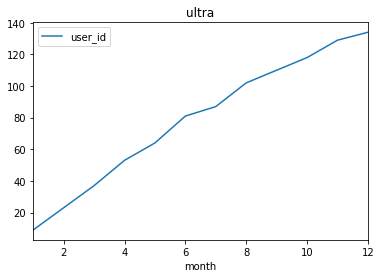

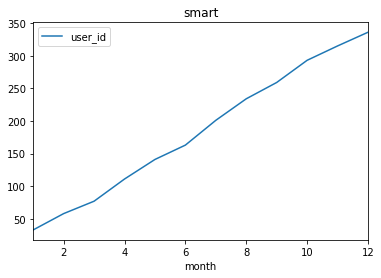

In [25]:
# помесячный график количества абонентов тарифов ultra и smart
data_ultra_user_count.plot(title = 'ultra')
data_smart_user_count.plot(title = 'smart')

У обоих тарифов наблюдается рост количества абонентов. Однако, судя по графику, кривая тарифа ultra скоро выйдет на насыщение, то есть прирост новых абонентов скоро заметно снизится. В то же время кривая тарифа smart больше похожа на прямую, то есть замедление роста количества новых абонентов пока не предвидится. 

Рассмотрим теперь абонентов, которые отказались от тарифов

In [26]:
# таблицы количества абонентов, которые отключились от тарифа
data_ultra_churn = data_users.query('tariff == "ultra" and churn_month != 0').pivot_table(index = 'churn_month', values = 'user_id', aggfunc = 'count')
data_smart_churn = data_users.query('tariff == "smart" and churn_month != 0').pivot_table(index = 'churn_month', values = 'user_id', aggfunc = 'count')

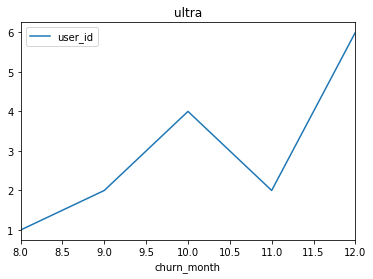

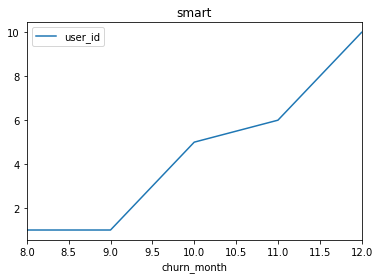

In [27]:
# помесячный график количества отказавшихся от каждого тарифа абонентов
data_ultra_churn.plot(title = 'ultra')
data_smart_churn.plot(title = 'smart')

Количество абонентов, которые отказались от тарифов, конечно, растет, но их ещё слишком мало, чтобы можно было делать какие то определенные выводы.

### Таблицы средних значений для пользователей отдельно по каждому тарифу

Рассмотрим сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.

In [28]:
# Разделяем одну таблицу на две: для каждого тарифа
data_ultra_average_per_user = data_per_month.query('tariff == "ultra"').pivot_table(index = ('user_id'))
data_smart_average_per_user = data_per_month.query('tariff == "smart"').pivot_table(index = ('user_id'))

#### Количество минут разговора

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12ff783850>]],
      dtype=object)

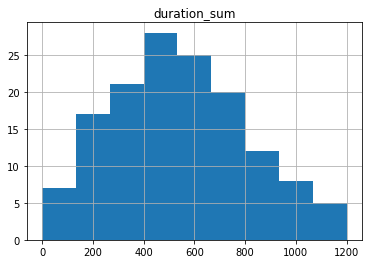

In [29]:
# Гистограммы среднего количества минут разговора пользователей тарифа ultra 
data_ultra_average_per_user.hist('duration_sum', bins = 'auto', range = (0, 1200))

In [30]:
# дисперсия
print('variance_estimate =', np.var(data_ultra_average_per_user['duration_sum'], ddof=1))

variance_estimate = 71872.0671269184


In [31]:
data_ultra_average_per_user['duration_sum'].describe()

count     143.000000
mean      546.998401
std       268.089662
min        16.500000
25%       342.883333
50%       525.500000
75%       750.000000
max      1179.363636
Name: duration_sum, dtype: float64

Дисперсия *variance_estimate* составила 71872  
Станартное отклонение *std* - 268  
Среднее *mean* - 547  
Гистограмма скошена вправо, так как среднее больше медианы (**50%** = 525.5). Максимальное значение (**max** = 1180) попадает в диапазон, образованный по правилу трех сигм (**50%** + 3 * **std**), то есть выбросов нет. При этом максимальное значение меньше, чем включенных в абонентскую плату минут разговора (3000 минут), почти в 3 раза, то есть абоненты не выговаривают включенных в тариф минут.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12ff792c10>]],
      dtype=object)

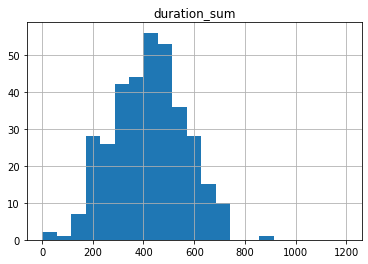

In [32]:
# Гистограммы среднего количества минут разговора пользователей тарифа smart
data_smart_average_per_user.hist('duration_sum', bins = 'auto', range = (0, 1200))

In [33]:
# дисперсия
print('variance_estimate =', np.var(data_smart_average_per_user['duration_sum'], ddof=1))

variance_estimate = 20578.276241342694


In [34]:
data_smart_average_per_user['duration_sum'].describe()

count    349.000000
mean     420.848019
std      143.451303
min       15.111111
25%      317.545455
50%      425.250000
75%      520.400000
max      891.500000
Name: duration_sum, dtype: float64

Дисперсия *variance_estimate* составила 20578  
Станартное отклонение *std* - 143  
Среднее *mean* - 421  
Гистограмма скошена влево, так как среднее меньше медианы (**50%** = 425.5). Максимальное значение (**max** = 891) не попадает в диапазон, образованный по правилу трех сигм (**50%** + 3 * **std**), то есть может считаться выбросом. В абонентскую плату включено 500 минут, что больше и среднего и медианы, но все равно существенное количество людей превышают абонентский лимит.

Если сравнивать гистограммы двух тарифов, то видно, что гистограмма тарифа smart значительно уже гистограммы тарифа ultra. Абоненты тарифа smart пытаются уложится в 500 минут, но получается это не у всех.

#### Количество сообщений

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12ff6d7890>]],
      dtype=object)

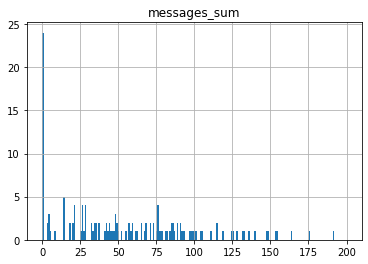

In [35]:
# Гистограммы среднего количества сообщений пользователей тарифа ultra
data_ultra_average_per_user.hist('messages_sum', bins = 201, range = (0, 200))

In [36]:
# дисперсия
print('variance_estimate =', np.var(data_ultra_average_per_user['messages_sum'], ddof=1))

variance_estimate = 2076.617144378509


In [37]:
data_ultra_average_per_user['messages_sum'].describe()

count    143.000000
mean      54.016958
std       45.569915
min        0.000000
25%       16.000000
50%       47.000000
75%       84.500000
max      192.000000
Name: messages_sum, dtype: float64

Дисперсия *variance_estimate* составила 2076  
Станартное отклонение *std* - 46  
Среднее *mean* - 54  
Гистограмма скошена вправо, так как среднее больше медианы (**50%** = 47). Максимальное значение (**max** = 192) не попадает в диапазон, образованный по правилу трех сигм (**50%** + 3 * **std**), то есть может считаться выбросом. В абонентскую плату включена 1000 сообщений, что больше максимального значения почти в 5 раз, то есть даже самым активным абонентам далеко до тарифного лимита. Также стоит отметить, что много абонентов вообще не отправляет сообщения

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12ff636310>]],
      dtype=object)

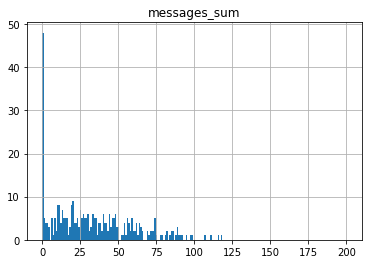

In [38]:
# Гистограммы среднего количества сообщений пользователей тарифа smart
data_smart_average_per_user.hist('messages_sum', bins = 201, range = (0, 200))

In [39]:
# дисперсия
print('variance_estimate =', np.var(data_smart_average_per_user['messages_sum'], ddof=1))

variance_estimate = 704.9430035009631


In [40]:
data_smart_average_per_user['messages_sum'].describe()

count    349.000000
mean      32.378557
std       26.550763
min        0.000000
25%       11.000000
50%       28.000000
75%       48.000000
max      118.000000
Name: messages_sum, dtype: float64

Дисперсия *variance_estimate* составила 705  
Станартное отклонение *std* - 27  
Среднее *mean* - 32  
Гистограмма скошена вправо, так как среднее больше медианы (**50%** = 28). Максимальное значение (**max** = 118) не попадает в диапазон, образованный по правилу трех сигм (**50%** + 3 * **std**), то есть может считаться выбросом. В абонентскую плату включены 50 сообщений. Среднее, медиана и даже третий квантиль меньше, чем тарифный лимит, но все равно находятся абоненты, которые превышают лимит. Также стоит отметить, что много абонентов вообще не отправляет сообщения

Если сравнивать гистограммы обоих тарифов, то можно отметить, что гистограмма тарифа smart гораздо уже гистограммы тарифа ultra, так как абоненты тарифа smart стараются уложится в лимит, но не у всех это получается.

#### Объем интернет-трафика

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12ff38a590>]],
      dtype=object)

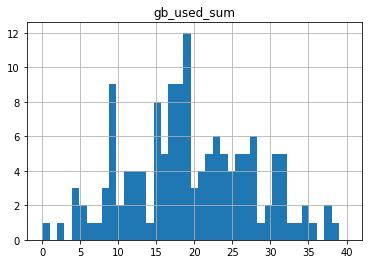

In [41]:
# Гистограммы среднего объема интернет-трафика пользователей тарифа ultra
data_ultra_average_per_user.hist('gb_used_sum', bins = 41, range = (0, 40))

In [42]:
# дисперсия
print('variance_estimate =', np.var(data_ultra_average_per_user['gb_used_sum'], ddof=1))

variance_estimate = 67.05943368705658


In [43]:
data_ultra_average_per_user['gb_used_sum'].describe()

count    143.000000
mean      19.583076
std        8.188982
min        0.000000
25%       14.454545
50%       18.800000
75%       25.533333
max       38.500000
Name: gb_used_sum, dtype: float64

Дисперсия *variance_estimate* составила 67  
Станартное отклонение *std* - 8  
Среднее *mean* - 20  
Гистограмма скошена вправо, так как среднее больше медианы (**50%** = 19), но различие минимально и можно говорить, что распределение почти нормальное. Максимальное значение (**max** = 39) попадает в диапазон, образованный по правилу трех сигм (**50%** + 3 * **std**), то есть выбросов нет. Ввиду нормальности распеделения можно сказать, что абоненты не следят за использованным интернет-трафиком

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12ff0d97d0>]],
      dtype=object)

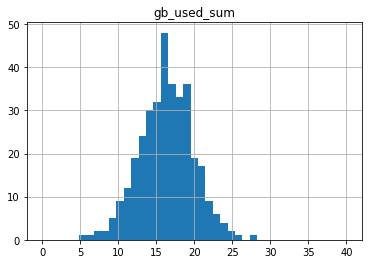

In [44]:
# Гистограммы среднего объема интернет-трафика пользователей тарифа smart
data_smart_average_per_user.hist('gb_used_sum', bins = 41, range = (0, 40))

In [45]:
# дисперсия
print('variance_estimate =', np.var(data_smart_average_per_user['gb_used_sum'], ddof=1))

variance_estimate = 12.387161861561518


In [46]:
data_smart_average_per_user['gb_used_sum'].describe()

count    349.000000
mean      16.346618
std        3.519540
min        5.727273
25%       14.000000
50%       16.333333
75%       18.750000
max       27.375000
Name: gb_used_sum, dtype: float64

Дисперсия *variance_estimate* составила 12  
Станартное отклонение *std* - 3.5  
Среднее *mean* - 16  
Гистограмма никуда не скошена, так как среднее равно медиане (**50%** = 16), таким образом распределение является нормальным. Максимальное значение (**max** = 28) не попадает в диапазон, образованный по правилу трех сигм (**50%** + 3 * **std**), то есть его можно считать выбросом. 

Если сравнивать гистограммы обоих тарифов, то видно следующее. Обе гистограммы имеют нормальное распределение, но гистограмма тарифа smart значительно уже. Основываясь на нормальности распределения тарифа ultra можно сказать, что абоненты не следят за использованным объемом интернет-трафика. Однако тоже самое нельзя сказать про абонентов тарифа smart, потому что у гистограммы этого тарифа максимум находится почти на уровне, отведенным тарифом (максимум на 16гб, а тарифный лимит на 15гб), то есть абоненты стремятся не сильно превышать тарифный лимит

#### Гистограммы выручки

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12fef77b50>]],
      dtype=object)

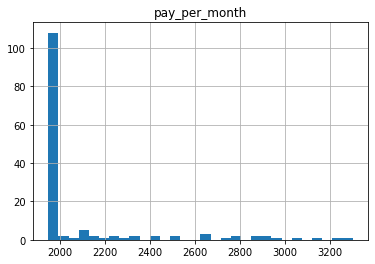

In [47]:
# Гистограмма средней выручки с абонентов тарифа ultra
data_ultra_average_per_user.hist('pay_per_month', bins = 30, range = (1950, 3300))

In [48]:
# дисперсия
print('variance_estimate =', np.var(data_ultra_average_per_user['pay_per_month'], ddof=1))

variance_estimate = 92339.79800848497


In [49]:
data_ultra_average_per_user['pay_per_month'].describe()

count     143.000000
mean     2086.974314
std       303.874642
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1981.250000
max      3262.500000
Name: pay_per_month, dtype: float64

Дисперсия *variance_estimate* составила 92340  
Станартное отклонение *std* - 304  
Среднее *mean* - 2087  
Гистограмма скошена вправа, так как среднее больше медианы (**50%** = 1950). Максимальное значение (**max** = 3263) не попадает в диапазон, образованный по правилу трех сигм (**50%** + 3 * **std**), то есть его можно считать выбросом.  
В целом, гистограмма показывает, что в подавляющем большинстве случаев абоненты не превышают лимиты тарифа.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12feebe150>]],
      dtype=object)

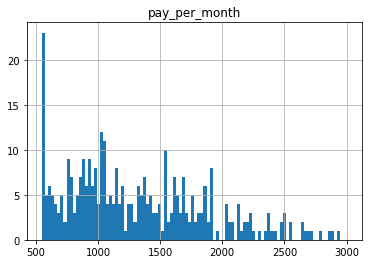

In [50]:
# Гистограмма средней выручки с абонентов тарифа smart
data_smart_average_per_user.hist('pay_per_month', bins = 100, range = (550, 3000))

In [51]:
# дисперсия
print('variance_estimate =', np.var(data_smart_average_per_user['pay_per_month'], ddof=1))

variance_estimate = 369738.45254042005


In [52]:
data_smart_average_per_user['pay_per_month'].describe()

count     349.000000
mean     1331.322579
std       608.061224
min       550.000000
25%       876.000000
50%      1189.800000
75%      1683.333333
max      4333.333333
Name: pay_per_month, dtype: float64

Дисперсия *variance_estimate* составила 369738  
Станартное отклонение *std* - 608  
Среднее *mean* - 1331  
Гистограмма скошена вправа, так как среднее больше медианы (**50%** = 1190). Максимальное значение (**max** = 4333) не попадает в диапазон, образованный по правилу трех сигм (**50%** + 3 * **std**), то есть его можно считать выбросом.  
В целом, гистограмма показывает, что в реднем менее 25% абонентов не превышают тарифные лимиты.

Сравнение двух гистограмм паказывает, что большинство абонентов тарифа ultra не превышают тарифные лимиты, в то время как в тарифе smart не превышают менее 25% абонентов.

#### Таблицы средних значений за каждый месяц отдельно для каждого тарифа

Далее для каждого тарифа представлены таблицы средних значений за месяц: минут разговора (**duration_sum**), количества сообщений (**messages_sum**), объема интернет-трафика (**gb_used_sum**), выручки (**pay_per_month**).

In [53]:
# Разделяем одну таблицу на две: для каждого тарифа
data_ultra_average_per_month = data_per_month.query('tariff == "ultra"').pivot_table(index = ('month'))
data_smart_average_per_month = data_per_month.query('tariff == "smart"').pivot_table(index = ('month'))

In [54]:
# Таблица средних значений за месяц для тарифа ultra
data_ultra_average_per_month.head(12)

,call_count,duration_sum,gb_used_sum,messages_sum,pay_per_month,user_id
month,,,,,,
1,46.666667,428.111111,13.333333,33.777778,1950.000000,1295.333333
2,35.478261,310.043478,12.478261,22.913043,1976.086957,1295.434783
3,54.243243,489.648649,17.702703,32.297297,2014.864865,1278.972973
4,54.000000,475.301887,17.566038,32.584906,2003.773585,1267.188679
5,60.687500,534.250000,19.734375,37.859375,2067.187500,1263.078125
6,56.012346,497.469136,18.938272,40.049383,2044.444444,1261.259259
7,64.091954,570.885057,20.482759,47.356322,2129.310345,1267.586207
8,60.313725,535.813725,19.598039,46.794118,2086.764706,1264.460784
9,63.145455,563.963636,19.109091,50.890909,2023.636364,1261.918182


In [55]:
# Таблица средних значений за месяц для тарифа smart
data_smart_average_per_month.head(12)

,call_count,duration_sum,gb_used_sum,messages_sum,pay_per_month,user_id
month,,,,,,
1,22.545455,210.030303,8.727273,17.939394,726.515152,1264.454545
2,32.568966,298.689655,11.844828,24.086207,827.603448,1280.896552
3,43.844156,390.051948,15.246753,31.857143,1164.623377,1256.792208
4,41.819820,370.441441,13.585586,30.585586,957.801802,1245.783784
5,44.198582,387.361702,15.943262,33.773050,1204.602837,1239.269504
6,44.760736,398.067485,16.000000,33.312883,1212.938650,1232.049080
7,45.791045,408.353234,15.910448,33.751244,1228.925373,1235.412935
8,47.457265,423.269231,16.807692,33.709402,1332.435897,1247.094017
9,48.262548,430.266409,16.420849,33.644788,1256.509653,1250.957529


В обеих таблицах средние значения за месяц минут разговора, количества сообщений, объема интернет-трафика выросли к конце года. Однако выручка продолжает расти только у тарифа smart, а у тарифа ultra выручка стабилизировалась на уровне 2050 - 2150.

### Вывод

1. В течение года наблюдается замедение роста количества новых абонентов тарифа ultra
2. В течение года количетсво новых абонентов тарифа smart растет стабильно
3. Количество абонентов, которые отказались от тарифа, недостаточно, чтобы можно было делать определенные выводы
4. Сравнение гистограмм количетсва минут двух тарифов показывает, что гистограмма тарифа smart значительно уже гистограммы тарифа ultra. Абоненты тарифа smart пытаются уложится в 500 минут, но получается это не у всех.
5. Сравнение гистограмм сообщений двух тарифов показывает, что гистограмма тарифа smart значительно уже гистограммы тарифа ultra. Абоненты тарифа smart пытаются уложится в 50 сообщений, но получается это не у всех.
6. Сравнение гистограмм объемов интернет-трафика оказывает, что гистограмма тарифа smart значительно уже гистограммы тарифа ultra. Абоненты тарифа ultra не следят за объемом интернет-трафика, потому что распределение почти нормальное и максимум находится далеко от тарифного лимита. В то же время гистограмма тарифа smart тоже имеет нормальное распределение, то максимум расположен почти на значении тарифного лимита, то есть абоненты стараются не сильно его превышать.
7. Сравнение двух гистограмм выручки паказывает, что большинство абонентов тарифа ultra не превышают тарифные лимиты, в то время как в тарифе smart не превышают менее 25% абонентов.
8. У обоих тарифов набюдает рост в течение года таких показателей, как количество минут, количество сообщений, объем интернет-трафика. Однако только у тарифа smart наблюдается рост выручки

## Проверка гипотез

### Гипотеза № 1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Сформулируем нулевую гипотезу так: средняя выручка пользователей тарифов «Ультра» и «Смарт» равна. Соответственно альтернативная гипотеза звучит так: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. Уровень статистической значимости определим как 0.05. Это стандартный уровень и нет причин в данный момент его менять.

In [62]:
# Проверка гипотезы
results = st.ttest_ind(
    data_ultra_average_per_user['pay_per_month'], 
    data_smart_average_per_user['pay_per_month'],
    equal_var = False)

In [65]:
print('p-значение:', results.pvalue)

p-значение: 6.337900158202743e-57


p-значение меньше уровня статистической значимости, поэтому нулевую гипотезу отвергает. Таким образом с хорошей вероятностью можно говорить, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается, то есть верна альтернативная гипотеза.

### Гипотеза № 2: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Проверять гипотезы будем отдельно для каждого тарифа.  
Сформулируем нулевую гипотезу так: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. Соответственно альтернативная гипотеза звучит так: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Уровень статистической значимости определим как 0.05. Это стандартный уровень и нет причин в данный момент его менять.  

In [70]:
# Объединяем таблицы так, чтобы в таблице со средними значениями появился столбец с городами
data_ultra_with_city = data_ultra_average_per_user.merge(data_users, on='user_id')
data_smart_with_city = data_smart_average_per_user.merge(data_users, on='user_id')

In [71]:
# Разделяем таблицы на оные, содержащие Москву и нет.
data_ultra_with_city_moscow = data_ultra_with_city.query('city == "Москва"')
data_ultra_with_city_others = data_ultra_with_city.query('city != "Москва"')
data_smart_with_city_moscow = data_smart_with_city.query('city == "Москва"')
data_smart_with_city_others = data_smart_with_city.query('city != "Москва"')

In [72]:
# Проверка гипотезы тарифа ultra
results = st.ttest_ind(
    data_ultra_with_city_moscow['pay_per_month'], 
    data_ultra_with_city_others['pay_per_month'])
print('p-значение:', results.pvalue)

p-значение: 0.5786280014271107


In [73]:
# Проверка гипотезы тарифа smart
results = st.ttest_ind(
    data_smart_with_city_moscow['pay_per_month'], 
    data_smart_with_city_others['pay_per_month'])
print('p-значение:', results.pvalue)

p-значение: 0.1630838578767174


В обоих случаяз p-значение значение оказалось больше уровень статистической значимости, значит, нулевые гипотезы верны. То есть средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов

### Вывод

1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
2. Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов

## Общий вывод

1. В течение года наблюдается замедение роста количества новых абонентов тарифа ultra
2. В течение года количетсво новых абонентов тарифа smart растет стабильно
3. Количество абонентов, которые отказались от тарифа, недостаточно, чтобы можно было делать определенные выводы
4. Сравнение гистограмм количетсва минут двух тарифов показывает, что гистограмма тарифа smart значительно уже гистограммы тарифа ultra. Абоненты тарифа smart пытаются уложится в 500 минут, но получается это не у всех.
5. Сравнение гистограмм сообщений двух тарифов показывает, что гистограмма тарифа smart значительно уже гистограммы тарифа ultra. Абоненты тарифа smart пытаются уложится в 50 сообщений, но получается это не у всех.
6. Сравнение гистограмм объемов интернет-трафика оказывает, что гистограмма тарифа smart значительно уже гистограммы тарифа ultra. Абоненты тарифа ultra не следят за объемом интернет-трафика, потому что распределение почти нормальное и максимум находится далеко от тарифного лимита. В то же время гистограмма тарифа smart тоже имеет нормальное распределение, то максимум расположен почти на значении тарифного лимита, то есть абоненты стараются не сильно его превышать.
7. Сравнение двух гистограмм выручки паказывает, что большинство абонентов тарифа ultra не превышают тарифные лимиты, в то время как в тарифе smart не превышают менее 25% абонентов.
8. У обоих тарифов набюдает рост в течение года таких показателей, как количество минут, количество сообщений, объем интернет-трафика. Однако только у тарифа smart наблюдается рост выручки
9. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается  
10. Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов  
11. Средняя выручка тарифа ultra больше, чем у тарифа smart, но у тарифа smart больше абонентов, поэтому общая выручка больше. Также у тарифа smart в течение года наблюдается рост как абонентов, так и средней выручки, чего не скажешь про тариф ultra.